<a href="https://colab.research.google.com/github/Bojescu/product_category_classifier/blob/main/notebook/eda_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load and Inspect the Dataset

The dataset is loaded directly from the GitHub repository using its **raw URL**.  
Column names are normalized to Python-friendly formats (no spaces or leading/trailing characters).  

**Steps performed:**
- Load the CSV file into a Pandas DataFrame.
- Rename columns (`product ID` → `product_id`, `Product Title` → `title`, etc.).
- Print the dataset shape (rows × columns).
- Display the first 5 rows for a quick overview.
- Show dataset information (`dtypes`, non-null counts) to identify missing values and data types.


In [9]:
import os
import pandas as pd

url = "https://raw.githubusercontent.com/Bojescu/product_category_classifier/main/data/products.csv"

df = pd.read_csv(url).rename(columns={
    'product ID':'product_id',
    'Product Title':'title',
    'Merchant ID':'merchant_id',
    ' Category Label':'category',
    '_Product Code':'product_code',
    'Number_of_Views':'views',
    'Merchant Rating':'merchant_rating',
    ' Listing Date  ':'listing_date',
})

print(df.shape)

print("\nFirst 5 rows:")
display(df.head())

print("\nDataset info:")
df.info()


(35311, 8)

First 5 rows:


,product_id,title,merchant_id,category,product_code,views,merchant_rating,listing_date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       35311 non-null  int64  
 1   title            35139 non-null  object 
 2   merchant_id      35311 non-null  int64  
 3   category         35267 non-null  object 
 4   product_code     35216 non-null  object 
 5   views            35297 non-null  float64
 6   merchant_rating  35141 non-null  float64
 7   listing_date     35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB


## 2. Missing Values and Data Types

A quick check is performed to identify missing values and inspect the data types of each column.  
This summary helps to:
- Detect columns with null values that may require cleaning or imputation.
- Confirm that each column has the expected data type.
- Provide an overview of dataset completeness before feature engineering.

The resulting table displays:
- **dtype**: the data type of the column.  
- **non_null**: the number of non-missing entries.  
- **nulls**: the number of missing entries.



In [10]:
# Missing values per column
df_info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "nulls": df.isna().sum(),
})
df_info


,dtype,non_null,nulls
product_id,int64,35311,0
title,object,35139,172
merchant_id,int64,35311,0
category,object,35267,44
product_code,object,35216,95
views,float64,35297,14
merchant_rating,float64,35141,170
listing_date,object,35252,59


## 3. Data Cleaning and Label Normalization

Basic preprocessing steps are applied to prepare the dataset for modeling:

- **Row filtering**: only rows with both `title` and `category` are kept.  
- **String normalization**: leading/trailing whitespace is removed, and values are cast to string type.  
- **Label normalization**: near-duplicate category names are mapped to a consistent form  
  (e.g., `CPU → CPUs`, `Mobile Phone → Mobile Phones`, `fridge → Fridges`).  

After cleaning, the following checks are performed:
- Dataset shape (rows × columns) after filtering.
- The number of unique categories available.
- Category distribution (counts per label).


In [11]:
# Keep only rows with both title and category present
df = df.dropna(subset=['title','category']).copy()

# Strip whitespace and cast to string
df['title'] = df['title'].astype(str).str.strip()
df['category'] = df['category'].astype(str).str.strip()

# Optional: normalize near-duplicate labels
norm_map = {
    'CPU': 'CPUs',
    'Mobile Phone': 'Mobile Phones',
    'fridge': 'Fridges',
}
df['category'] = df['category'].map(lambda x: norm_map.get(x, x))

print("After cleaning:", df.shape)
print("Unique categories:", df['category'].nunique())
df['category'].value_counts().to_frame('count')


After cleaning: (35096, 8)
Unique categories: 10


,count
category,
Fridge Freezers,5470
Mobile Phones,4057
Washing Machines,4015
CPUs,3831
Fridges,3559
TVs,3541
Dishwashers,3405
Digital Cameras,2689
Microwaves,2328


## 4. Category Distribution Visualization

A bar chart is plotted to show the frequency of products in each category.  
This visualization helps to quickly identify **class imbalance**, which is important for model training and evaluation.

- **X-axis**: product categories.  
- **Y-axis**: number of products in each category.  
- Categories with higher counts dominate the dataset, while those with fewer samples may require special handling (e.g., rebalancing, class weighting).


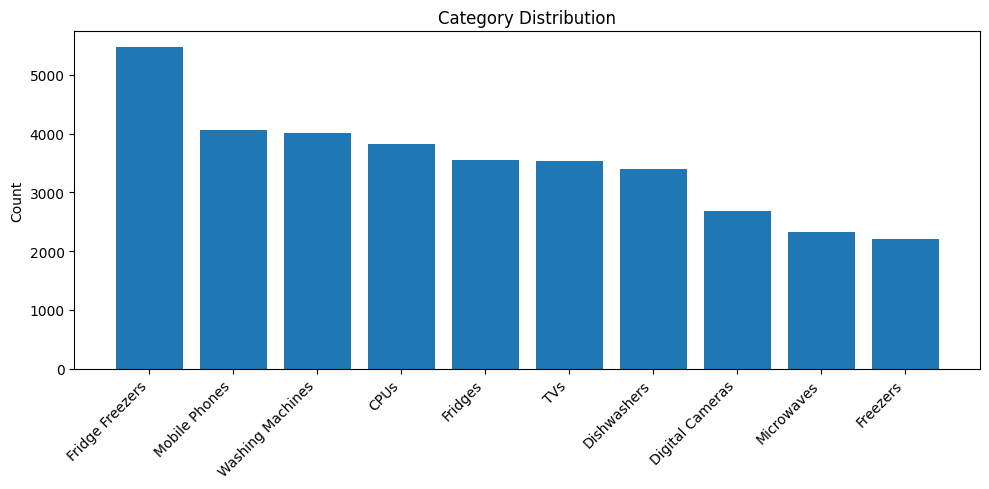

In [12]:
# Simple category distribution plot
import matplotlib.pyplot as plt

vc = df['category'].value_counts()
plt.figure(figsize=(10,5))
plt.bar(vc.index, vc.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Category Distribution")
plt.tight_layout()
plt.show()


## 5. Feature Engineering and Data Preparation

A preprocessing pipeline is defined to transform raw product titles into numerical features suitable for machine learning models.

**Custom numeric features extracted from titles:**
- `len_chars`: total number of characters in the title.  
- `word_count`: total number of words.  
- `digit_ratio`: ratio of digits to total characters.  
- `upper_ratio`: ratio of uppercase letters to total characters.  
- `max_word_len`: length of the longest word.  
- `has_storage_unit`: indicator if storage units like *GB*, *TB*, *MB* appear.  
- `has_model_code`: indicator if the title contains a brand/model code pattern.

**Text vectorization:**
- **Word-level TF-IDF** (1–2 n-grams).  
- **Character-level TF-IDF** (3–4 n-grams).  

These transformations are combined using a `ColumnTransformer`, together with the numeric features (scaled using `StandardScaler`).  

Finally, the dataset is split into **training (80%)** and **validation (20%)** sets using stratification to preserve class balance.


In [13]:
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def title_stats(X):
    titles = pd.Series(X).fillna("")
    def digit_ratio(s): return (sum(ch.isdigit() for ch in s)/len(s)) if s else 0.0
    def upper_ratio(s): return (sum(ch.isupper() for ch in s)/len(s)) if s else 0.0
    def word_count(s): return len(s.split())
    def max_word_len(s): return max([len(w) for w in s.split()]) if s.strip() else 0
    def has_storage_unit(s): return int(bool(re.search(r"\b(\d+\s?(gb|tb|mb))\b", s, flags=re.I)))
    def has_model_code(s): return int(bool(re.search(r"[A-Za-z]{1,5}\d{2,}", s)))
    feats = pd.DataFrame({
        "len_chars": titles.map(len).astype(float),
        "word_count": titles.map(word_count).astype(float),
        "digit_ratio": titles.map(digit_ratio).astype(float),
        "upper_ratio": titles.map(upper_ratio).astype(float),
        "max_word_len": titles.map(max_word_len).astype(float),
        "has_storage_unit": titles.map(has_storage_unit).astype(float),
        "has_model_code": titles.map(has_model_code).astype(float),
    })
    return feats.values

stats_transformer = FunctionTransformer(title_stats, validate=False)
stats_pipeline = Pipeline([("stats", stats_transformer), ("scaler", StandardScaler(with_mean=False))])

tfidf_word = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=3, max_features=30000, strip_accents='unicode')
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,4), min_df=5, max_features=30000)

preproc = ColumnTransformer([
    ("tfidf_word", tfidf_word, "title"),
    ("tfidf_char", tfidf_char, "title"),
    ("stats", stats_pipeline, "title"),
], remainder='drop')

X = df[['title']]
y = df['category']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_valid.shape


((28076, 1), (7020, 1))

## 6. Model Training and Comparison

Five different classifiers are trained and evaluated using the same preprocessing pipeline:

- **Logistic Regression** (linear model with probability estimates).  
- **Multinomial Naive Bayes** (probabilistic baseline for text).  
- **Decision Tree** (non-linear model with interpretable splits).  
- **Random Forest** (ensemble of decision trees, robust to overfitting).  
- **Linear SVC** (linear support vector machine, efficient for high-dimensional text data).  

**Process:**
1. For each model, a pipeline is created combining preprocessing and the classifier.  
2. The model is trained on the training set and evaluated on the validation set.  
3. Training time and validation accuracy are recorded.  
4. A detailed classification report (precision, recall, F1-score) is stored for each model.  

The results are summarized in a table showing **accuracy** and **training time** for easy comparison.


In [14]:
from time import time

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MultinomialNB": MultinomialNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC(),
}

results = []
reports = {}
pipes = {}

for name, clf in models.items():
    pipe = Pipeline([("prep", preproc), ("clf", clf)])
    t0 = time()
    pipe.fit(X_train, y_train)
    train_s = time() - t0

    pred = pipe.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    rep = classification_report(y_valid, pred, digits=3)

    results.append({"model": name, "accuracy": acc, "train_sec": train_s})
    reports[name] = rep
    pipes[name] = pipe

# Summary table
res_df = pd.DataFrame(results).sort_values("accuracy", ascending=False).reset_index(drop=True)
res_df


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,model,accuracy,train_sec
0,LinearSVC,0.992593,33.119535
1,LogisticRegression,0.985755,96.445559
2,RandomForest,0.983618,74.788306
3,DecisionTree,0.969088,19.484370
4,MultinomialNB,0.954701,4.134176


## 7. Detailed Classification Reports

For each trained model, a full **classification report** is generated and displayed.  
The report includes, for every category:

- **Precision** — proportion of correctly predicted items among all predicted items for that class.  
- **Recall** — proportion of correctly predicted items among all true items for that class.  
- **F1-score** — harmonic mean of precision and recall, balancing both metrics.  
- **Support** — the number of true instances for that class in the validation set.  

Additionally, overall averages (macro, weighted) are shown.  
This detailed view highlights which categories are classified well and where misclassifications occur, guiding further improvements.


In [15]:
for r in results:
    name = r["model"]
    print("="*90)
    print(f"{name} | accuracy={r['accuracy']:.4f} | train_time={r['train_sec']:.1f}s")
    print(reports[name])


LogisticRegression | accuracy=0.9858 | train_time=96.4s
                  precision    recall  f1-score   support

            CPUs      0.999     0.995     0.997       766
 Digital Cameras      0.994     0.996     0.995       538
     Dishwashers      0.996     0.993     0.994       681
        Freezers      0.986     0.977     0.982       440
 Fridge Freezers      0.983     0.977     0.980      1094
         Fridges      0.957     0.958     0.957       712
      Microwaves      0.987     0.989     0.988       466
   Mobile Phones      0.991     0.995     0.993       812
             TVs      0.987     0.994     0.991       708
Washing Machines      0.981     0.986     0.984       803

        accuracy                          0.986      7020
       macro avg      0.986     0.986     0.986      7020
    weighted avg      0.986     0.986     0.986      7020

MultinomialNB | accuracy=0.9547 | train_time=4.1s
                  precision    recall  f1-score   support

            CPUs    

## 8. Accuracy Comparison Chart

A bar chart is plotted to visually compare the **validation accuracy** of all trained models.  

- **X-axis**: model names.  
- **Y-axis**: accuracy score (from 0 to 1).  

This visualization makes it easier to identify which algorithm performs best overall and to spot large differences between models.  
It complements the classification reports by providing a high-level overview of performance.


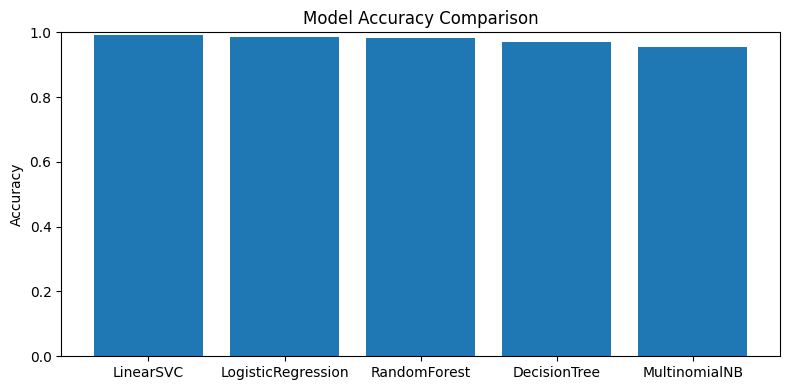

In [16]:
# Accuracy bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(res_df["model"], res_df["accuracy"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()
